In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from data.data_handler import CondDataset
from cond_trainer import CondTrainer
from models.layers import MVN, Latent, ST, Normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
use_cuda =False# torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [3]:
data_dir = "data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")
df = stocks.copy().set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan
mu = df.mean()
std = df.std()
rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
Y = rates.join(cmdty).join(index)
Y = Y.reindex(df.index).fillna(method="pad")["OMX"]
Y.shape, df.shape

((5208,), (5208, 2975))

In [4]:
T = 61
n_x = 1

scaler = StandardScaler()

X = []
y = []
t_list = []
t_dict = {}
steps = len(df) // T
windows = 100

def make_one_hot(labels, C = 5):
    y = torch.eye(C) 
    return y[labels.long()].squeeze(1)

def calc_y(y):
    ret = y.iloc[-1]/y.iloc[0] - 1
    std = y.pct_change().std()*np.sqrt(252)
    #print(ret, std)
    if ret > 0.12:
        return 0
    elif ret <= 0.12 and ret > 0.03:
        return 1
    elif ret <= 0.03 and ret > -0.03:
        return 2
    elif ret <= -0.03 and ret > -0.12:
        return 3
    elif ret <= -0.12:
        return 4
#     if ret > 0:
#         return 0
#     else:
#         return 1

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].dropna(axis=1, thresh = 55).fillna(0.0)
    y_t = Y.iloc[t*T:(t+1)*T]
    y_t = calc_y(y_t)
    #y_t = y_t.iloc[-1] / y_t.iloc[0] - 1
    #calc_y(y_t)
    #df_t = df_t.sub(df_t.mean(), axis=1).div(df_t.std(), axis=1).dropna(axis=1)
    t_dict[t] = (df_t.index[0], df_t.index[-1])
    if df_t.shape[1] < n_x:
        continue
    for _ in range(windows):
        t_list.append([t])
        i = np.random.choice(np.arange(df_t.shape[1]), n_x, replace=False)
        df_t_i = df_t.iloc[:,i]
        #df_t_i = df_t_i.sub(df_t_i.mean(), axis=1).div(df_t_i.std(), axis=1)
        X.append(df_t_i.values.reshape(-1,1).squeeze())
        #y.append(y_t.values.reshape(-1,1).squeeze())
        y.append([y_t])
#     for _ in range(df_t.shape[1]):
#         t_list.append([t])
#         y.append([y_t])
#         X.append(df_t.iloc[:,_].values.reshape(-1,1).squeeze())
    
    

X = np.array(X)
y = np.array(y)
t_arr = np.array(t_list)
y.shape, X.shape, t_arr.shape

((8400, 1), (8400, 61), (8400, 1))

(array([ 500.,    0., 3800.,    0.,    0., 1800.,    0., 1300.,    0.,
        1000.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

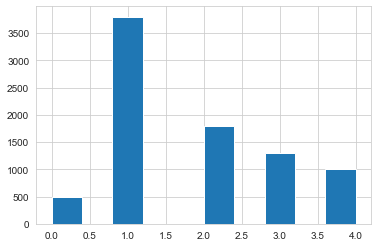

In [5]:
plt.hist(y)

In [6]:

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y,t_arr, test_size = 0.2, random_state = 42)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)
# y_scaler = StandardScaler()
# y_train  = y_scaler.fit_transform(y_train)
# y_test = y_scaler.transform(y_test)

In [7]:
train_data = CondDataset(torch.from_numpy(X_train), torch.from_numpy(y_train), torch.from_numpy(t_train))
test_data = CondDataset(torch.from_numpy(X_test), torch.from_numpy(y_test), torch.from_numpy(t_test))

In [8]:
x,y,t = train_data[:32]
make_one_hot(y).shape

torch.Size([32, 5])

In [9]:
class CVAE(nn.Module):
    def __init__(self, T, n_x, n_y, n_z):
        super().__init__()
        
        mult = 80
        
        self.enc = nn.Sequential(
            nn.Linear(T*n_x+n_y, mult*5),
            nn.BatchNorm1d(mult*5),
            nn.ELU(),
            
            nn.Linear(mult*5, mult*3),
            nn.BatchNorm1d(mult*3),
            nn.ELU(),
            
            nn.Linear(mult*3, mult*2),
            nn.BatchNorm1d(mult*2),
            nn.ELU(),
            
            Latent(mult*2, n_z)
        )
        
        self.prior = nn.Sequential(
            nn.Linear(n_y, mult*2),
            nn.BatchNorm1d(mult*2),
            nn.ELU(),
            Latent(mult*2, n_z)
        )
        
        self.dec = nn.Sequential(
            nn.Linear(n_y + n_z, mult*2),
            nn.BatchNorm1d(mult*2),
            nn.ELU(),
            
            nn.Linear(mult*2, mult*3),
            nn.BatchNorm1d(mult*3),
            nn.ELU(),
            
            
            nn.Linear(mult*3, mult*5),
            nn.BatchNorm1d(mult*5),
            nn.ELU(),
            
            Normal(mult*5, T*n_x)
        )
    
    def _dkl_loss(self, prior_mean, prior_log_var, z_mean, z_log_var):
        z_var = z_log_var.exp()
        prior_var = prior_log_var.exp()
        kld = torch.sum(prior_log_var - z_log_var + ((z_var + (z_mean - prior_mean).pow(2)) / (prior_var*2)) - 0.5)
        return kld
    
    def _rcl_loss(self, dist, x):
        return -dist.log_prob(x).sum()
    
    def encode(self, x,y):
        x = torch.cat([x,y], 1)
        return self.enc(x)

    def decode(self, z, y):
        z = torch.cat([z,y], 1)
        return self.dec(z)
    
    def forward(self, x, y, beta = 1.0):
        y = make_one_hot(y)
        z, mu, log_var = self.encode(x,y)
        prior, prior_mu, prior_log_var = self.prior(y)
        dkl = self._dkl_loss(prior_mu, prior_log_var, mu, log_var)
        dist = self.decode(z,y)
        rcl = self._rcl_loss(dist, x)
        
        return dist, rcl + dkl*beta

In [10]:
n_z = 2
n_y = 5
vae = CVAE(T, n_x, n_y, n_z)
t = CondTrainer(vae, train_data, train_data, use_cuda)

In [11]:
losses = t.fit(200, burn_in = 10)

Epoch: 0, Train Loss: 74.84, Test Loss:  75.27
Epoch: 10, Train Loss: 64.14, Test Loss:  63.03
Epoch: 20, Train Loss: 68.37, Test Loss:  67.77
Epoch: 30, Train Loss: 67.61, Test Loss:  66.66
Epoch: 40, Train Loss: 67.45, Test Loss:  66.28
Epoch: 50, Train Loss: 66.75, Test Loss:  65.63
Epoch: 60, Train Loss: 66.45, Test Loss:  68.10
Epoch: 70, Train Loss: 66.27, Test Loss:  65.37
Epoch: 80, Train Loss: 66.21, Test Loss:  66.02
Epoch: 90, Train Loss: 66.16, Test Loss:  65.22
Epoch: 100, Train Loss: 65.87, Test Loss:  65.26
Epoch: 110, Train Loss: 65.93, Test Loss:  64.90
Epoch: 120, Train Loss: 65.71, Test Loss:  64.86
Epoch: 130, Train Loss: 65.64, Test Loss:  64.64
Epoch: 140, Train Loss: 65.66, Test Loss:  64.63
Epoch: 150, Train Loss: 65.49, Test Loss:  64.86


KeyboardInterrupt: 

In [ ]:
losses[losses < 100].plot()


In [12]:
vae.eval()

CVAE(
  (enc): Sequential(
    (0): Linear(in_features=66, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=400, out_features=240, bias=True)
    (4): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=240, out_features=160, bias=True)
    (7): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Latent(
      (mu): Linear(in_features=160, out_features=2, bias=True)
      (log_var): Linear(in_features=160, out_features=2, bias=True)
    )
  )
  (prior): Sequential(
    (0): Linear(in_features=5, out_features=160, bias=True)
    (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Latent(
      (mu): Linear(in_features=160, out_features=2, bias=True)
      (log_

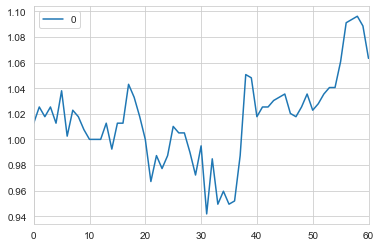

In [13]:
x, y, t= test_data[:32]
y = make_one_hot(y)
z, mu, log_var = vae.encode(x,y)
dist = vae.decode(z,y )
x_df = pd.DataFrame(X_scaler.inverse_transform(x[6].detach().numpy()).reshape(T,n_x))
(1.0 + x_df).cumprod().plot()

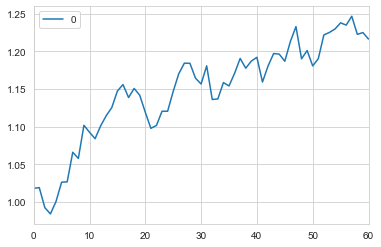

In [17]:
x_df = pd.DataFrame(X_scaler.inverse_transform(dist.sample()[6].detach().numpy()).reshape(T,n_x))
(1.0 + x_df).cumprod().plot()

tensor([-0.4688,  0.2359], grad_fn=<MeanBackward1>) tensor([ 4.2049, 10.5673], grad_fn=<PowBackward0>)


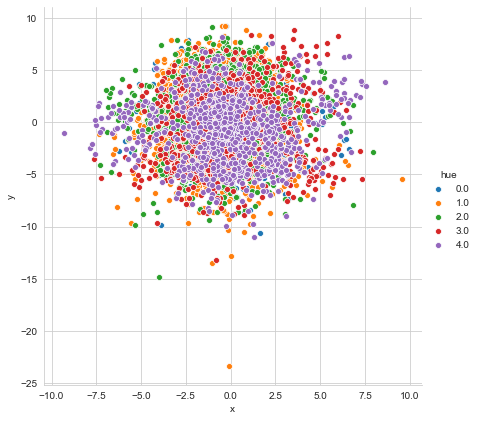

In [18]:
idx = np.random.choice(np.arange(len(train_data)), len(train_data), replace=False)
X,y,t  = train_data[idx]
y_ = make_one_hot(y)
z, mu, log_var = vae.encode(X,y_)
z_df = pd.DataFrame(z.detach().numpy(), columns = ["x", "y"])
#z_df.columns = ["x", "y"]
z_df["hue"] = y.detach().numpy()[:,0]
g = sns.pairplot(x_vars="x", y_vars = "y", hue="hue", height=6, data=z_df)
print(z.mean(dim=0), z.std(dim=0)**2)

In [19]:
def gradmvn(x, dist):
    mu = dist.mean
    Sigma = dist.covariance_matrix + 0.02*torch.ones(x.size(0), x.size(1)).diag_embed()
    Sigma_inv = torch.inverse(Sigma)
    bb = (x - mu).unsqueeze(2)
    #print(bb.shape, Sigma_inv.shape)
    return bb.transpose(1,2).bmm(Sigma_inv).squeeze(1)

def grad(x, dist):
    df = dist.df
    return x * (df + 1) / (df + x**2)

def grad(x, dist):
    mu = dist.mean
    sigma = dist.scale
    grad = (x - mu) / sigma.pow(2)
    return grad
    

def sgd(x, y, vae, N=200, alpha=1, eps = 1):
    z_list = []
    for i in range(N):
        eps = eps / np.sqrt(i+1)
        x_z = x + np.sqrt(eps) * torch.randn_like(x)
        #print(x_z.shape, "x")
        z, mu, log_var = vae.encode(x_z, y)
        dist = vae.decode(z,y)
        z_list.append(mu.unsqueeze(1))
        g = grad(x_z, dist)
        #print(g.shape, "G")
        x = x - alpha * g / np.sqrt(i+1)
    return torch.cat(z_list, 1)

In [20]:
x,y,t = train_data[3:4]
y = make_one_hot(y)
print(x.shape, y.shape)
z_list = sgd(x,y,vae, 2000, .1, 3)

torch.Size([1, 61]) torch.Size([1, 5])


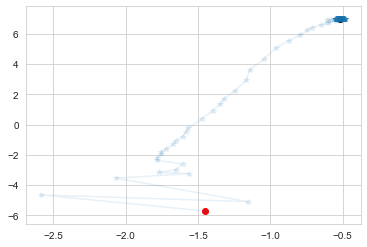

In [21]:
zz = z_list.detach().numpy()
_ = plt.plot(zz[0,:,0], zz[0,:,1],"*-" ,alpha=0.1)
_ = plt.scatter(zz[0,0,0], zz[0,0,1], c="r")
_ = plt.scatter(zz[0,-1,0], zz[0,-1,1], c="black")

In [22]:
print(len(train_data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(train_data)), 1600, replace=False)
    X, Y,t = train_data[idx]
    Y_ = make_one_hot(Y)
    zz = sgd(X, Y_, vae, 2000, .1, 1)
    

6720


In [23]:
from sklearn.manifold import TSNE

In [24]:

zz_df = pd.DataFrame(zz[:,-1].detach().numpy(), columns=["x","y"])
zz_df["hue"] = Y.detach().numpy()[:,0]
zz_first_df = pd.DataFrame(zz[:,0].detach().numpy(), columns = ["x","y"])
zz_first_df["hue"] = Y.detach().numpy()[:,0]

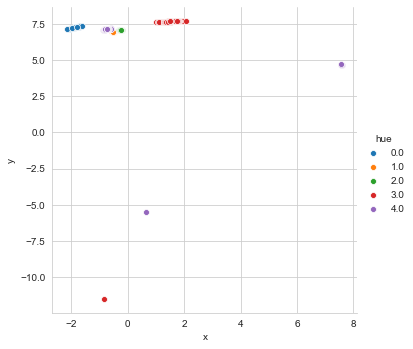

In [25]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="hue", data=zz_df, height=5)

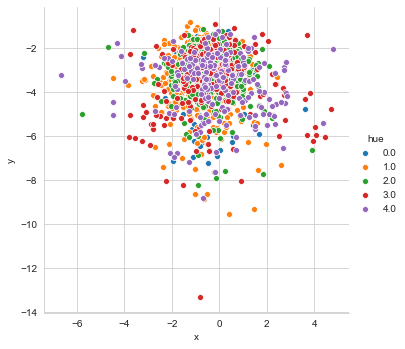

In [26]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="hue", data=zz_first_df, height=5)

torch.Size([1, 2]) torch.Size([1, 5])


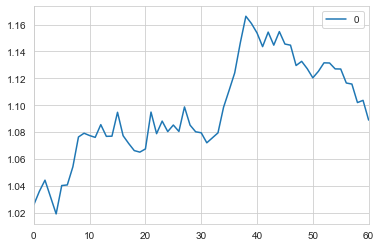

In [59]:
z = torch.Tensor([-2, 7.5]).unsqueeze(0)
y = make_one_hot(torch.Tensor([4]))
print(z.shape, y.shape)
dist = vae.decode(z, y)
v = pd.DataFrame(X_scaler.inverse_transform(dist.sample()[0]))
(1.0 + v).cumprod().plot()

In [ ]:
zz_df[zz_df.hue == 0].round(2).drop_duplicates().mean()

In [ ]:
from sklearn.decomposition import PCA
p = PCA(2).fit_transform(zz[:,-1].detach().numpy())
p = pd.DataFrame(p, columns = ["x", "y"])
p["hue"] = Y.detach().numpy()[:,0]
sns.pairplot(x_vars = "x", y_vars = "y", hue="hue", data=p, height=5)

In [ ]:
p.shape, Y.shape

In [ ]:
z = torch.Tensor([-0.77, -3.935]).unsqueeze(0)
y = make_one_hot(torch.Tensor([4]))
print(z.shape, y.shape)
dist = vae.decode(z,y)

In [ ]:
s = []
for _ in range(10000):
    sam = dist.sample().detach().numpy()
    sam = X_scaler.inverse_transform(sam).reshape(T,n_x)
    s.append(sam)
s = np.array(s)

In [ ]:
m = pd.DataFrame(s.mean(axis=0))
(1.0 + m).cumprod().plot()

In [ ]:
zz_df["t"] = t.detach().numpy()[:,0]
df = zz_df.dropna()

In [ ]:
from sklearn.cluster import KMeans
kk = KMeans(5).fit_predict(df)
df["label"] = kk
plt.hist(kk)

In [ ]:
fig, ax = plt.subplots()
for name, grp in df.groupby("label"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()
plt.show()

In [ ]:
s = df.groupby("t").mean()["label"]

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
a = pd.DataFrame(acf(s))
a.plot(kind="bar")

In [ ]:
s.plot()